In [32]:
import torch
from torch.nn import Sequential, Linear, Parameter, ReLU
import torch.nn.functional as F

import torch_geometric
from torch_geometric.nn import MessagePassing, GeneralConv, GCNConv
from torch_geometric.data import Data
from torch_geometric.utils import add_self_loops, segregate_self_loops, to_networkx
from typing import Any, Dict, List, Optional, Union
from torch import Tensor
from torch_geometric.nn.aggr import Aggregation
from torch_geometric.typing import Adj, OptTensor

%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt


In [39]:
from typing import Optional


from torch import Tensor


class GNNSConv(MessagePassing):
    def __init__(self, in_channels: int, out_channels: int, num_edge_features: int, alpha: float = 0.01) -> None:
        """
        Args:
            in_channels: число фичей в вершинах графа
            alpha: параметр для учета величины обновления X
        """
        super().__init__(aggr="add")
        self.alpha = alpha
        self.in_channels = in_channels
        self.out_channels = out_channels

        self.linear = Linear(in_channels, out_channels, bias=False)
        self.num_edge_features = num_edge_features

        self.mlp_in = Sequential(
            Linear(2 * in_channels + num_edge_features, out_channels),
            ReLU(),
            Linear(out_channels, out_channels)
        )

        self.mlp_out = Sequential(
            Linear(2 * in_channels + num_edge_features, out_channels),
            ReLU(),
            Linear(out_channels, out_channels)
        )

        self.mlp_psi = Sequential(
            Linear(3 * out_channels, out_channels),
            ReLU(),
            Linear(out_channels, out_channels)
        )        

        self.mode = 'global_update' 

        self.reset_parameters()

    def reset_parameters(self):
        self.linear.reset_parameters()
        # self.bias.zero_()

    def forward(self, x: Tensor, edge_index: Adj,
                node_attr: Tensor,
                edge_attr: Tensor) -> Tensor:
        """
        Args:
            x: Данные размерностью [num_nodes, num_features]  (num_features := in_channels) 
            edge_index has shape [2, num_edges]
        """
        # x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        
        self.mode == 'local_update'

        # Формирование сообщения j -> i
        self.flow = 'source_to_target'
        phi_in = self.propagate(edge_index, x=x, edge_attr=edge_attr)

        # Формирование сообщения i -> j
        self.flow = 'target_to_source'
        phi_out = self.propagate(edge_index, x=x, edge_attr=edge_attr)

        # Объединение сообщений
        self.mode = 'global_update'
        out = self.propagate(edge_index, x=x, edge_attr=edge_attr, phi_in=phi_in, phi_out=phi_out)

        # ResNet fashion
        out = x + self.alpha * out

        return out

    def message(self, x_i: Tensor, x_j: Tensor, edge_attr: OptTensor, phi_in_i: OptTensor = None, phi_out_i: OptTensor  = None) -> Tensor:
        """
        Args:
            x_i: Target node features [num_edges, num_features]
            x_j: Source node features [num_edges, num_features]
        """
        if phi_in_i and phi_out_i:
            return torch.cat([x_i, phi_in_i, phi_out_i], dim=-1)

        mlp = self.mlp_in if self.flow == "source_to_target" else self.mlp_out
        tmp = torch.cat([x_i, x_j, edge_attr], dim=-1) 
        return mlp(tmp)
    
    def aggregate(self, inputs: Tensor, index: Tensor, ptr: Tensor | None = None, dim_size: int | None = None) -> Tensor:
        
        if  self.mode == 'global_update':
            return inputs
        
        return super().aggregate(inputs, index, ptr, dim_size)

    def update(self, inputs: Tensor, phi_in_i: OptTensor = None, phi_out_i: OptTensor  = None) -> Tensor:
        return inputs if self.mode == 'local_update' else self.mlp_psi(inputs)
        
    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}({self.in_channels}, '
                f'{self.out_channels}, aggr={self.aggr})')


In [40]:
def visualize_graph(G, color):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                     node_color=color, cmap="Set2")
    plt.show()

/home/ab/anaconda3/envs/nfsolver/lib/python3.11/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


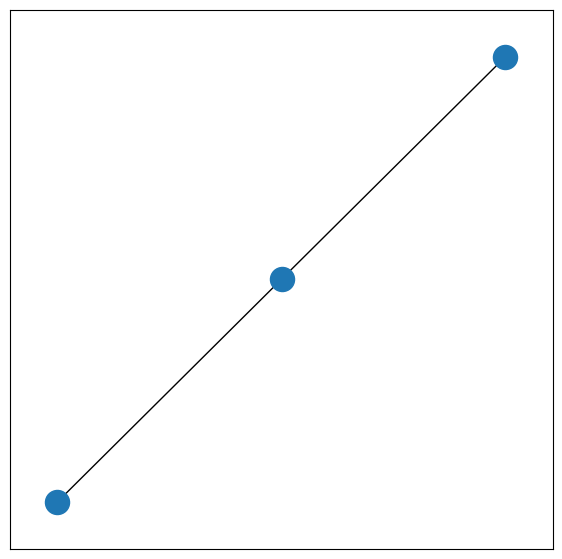

In [41]:
edge_index = torch.tensor([
  [0, 1],
  [1, 2]
], dtype=torch.long)

# edge_index, _ = add_self_loops(edge_index)

# edge_index, edge_attr, loop_edge_index, loop_edge_attr = segregate_self_loops(edge_index)

x = torch.tensor([[-1, 1], [0, 1], [1, 1]], dtype=torch.float)
edge_attr = torch.tensor([
  [4, 5],
  [6, 7]
])

data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)

G = to_networkx(data, to_undirected=True)
visualize_graph(G, color=data.y);

In [44]:
class GNNSolver(torch.nn.Module):
    def __init__(self, num_features: int, num_classes: int, num_edge_features: int) -> None:
        super().__init__()
        torch.manual_seed(1234)
        self.conv1 = GNNSConv(in_channels=num_features, out_channels=4, num_edge_features=num_edge_features)
        self.conv2 = GNNSConv(4, 4, num_edge_features)
        self.conv3 = GNNSConv(4, 2, num_edge_features)
        self.classifier = Linear(2, num_classes)

    def forward(self, x, edge_index, node_attr, edge_attr):
        h = self.conv1(x, edge_index, node_attr, edge_attr)
        h = F.elu(h)
        h = self.conv2(h, edge_index)
        h = F.elu(h)
        h = self.conv3(h, edge_index)
        h = F.elu(h)

        out = self.classifier(h)

        return out, h
    
model = GNNSolver(num_features=data.num_features, num_classes=2, num_edge_features=data.num_edge_features)
print(model)

GNNSolver(
  (conv1): GNNSConv(2, 4, aggr=add)
  (conv2): GNNSConv(4, 4, aggr=add)
  (conv3): GNNSConv(4, 2, aggr=add)
  (classifier): Linear(in_features=2, out_features=2, bias=True)
)


In [45]:
_, h = model(data.x, data.edge_index, data.node_attrs, data.edge_attr)


RuntimeError: mat1 and mat2 shapes cannot be multiplied (2x4 and 12x4)